# Segmenting and Clustering Neighborhoods in Toronto

# Scrapping from Wiki page

In [43]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 

In [44]:
URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
content = requests.get(URL)

In [45]:
soup = BeautifulSoup(content.text, 'lxml')

In [46]:
table= soup.find('table', { "class" : "wikitable sortable"}) # Use dictionary to pass key : value pair


In [47]:
df = pd.read_html(str(table))[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [48]:
df.shape

(288, 3)

Drop non assigned borough

In [49]:
df1=df[df['Borough'] != 'Not assigned' ]

In [50]:
df1.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [51]:
df1.shape

(211, 3)

In [52]:
df2=df1.groupby(['Postcode','Borough'])['Neighbourhood'].apply(','.join).to_frame()

In [53]:
df2.head()

,,Neighbourhood
Postcode,Borough,
M1B,Scarborough,"Rouge,Malvern"
M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
M1E,Scarborough,"Guildwood,Morningside,West Hill"
M1G,Scarborough,Woburn
M1H,Scarborough,Cedarbrae


In [54]:
df3=df2.reset_index()

In [55]:
df3.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [56]:
df3['Neighbourhood'] = df3['Borough'].where(df3['Neighbourhood']=='Not assigned',df3['Neighbourhood'])

In [57]:
df3[df3['Postcode'] == 'M7A']

,Postcode,Borough,Neighbourhood
85,M7A,Queen's Park,Queen's Park


In [58]:
df3=df3.rename(index=str, columns={"Postcode": "Postal Code"})
df3=df3.rename(index=str, columns={"Neighbourhood": "Neighborhood"})

## dataframe without geo data 

In [182]:
df3.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Getting the geo database

Could not make the geocoder works... So I took the csv file

In [183]:
url1="https://cocl.us/Geospatial_data"
geo=pd.read_csv(url1)

In [184]:
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## Merging geodata with initial database to get the final data base

In [185]:
neighborhoods= pd.merge(df3, geo)
neighborhoods.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [63]:
neighborhoods.tail()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village,Martin Grove Gardens,Richvie...",43.688905,-79.554724
101,M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739416,-79.588437
102,M9W,Etobicoke,Northwest,43.706748,-79.594054


In [64]:
neighborhoods.shape

(103, 5)

In [65]:
print('The dataframe has {} boroughs and {} postal codes.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 11 boroughs and 103 postal codes.


for comparison, New york as 5 borough and 306 neighborhoods! However, here some neighboroods are merged under a single postal code...
Appears a bit strange for me to have merged the neighborhoods under single post code, especially if we want to compare with previous work on NYC.

### Getting Toronto geo data

In [187]:
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode('Toronto, Ontario')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Toronto map with post code labels

In [189]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood, postal_code in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood'],neighborhoods['Postal Code']):
    label = '{}, {}'.format(postal_code,neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Define Foursquare API identifier plus make the function to collect data


Get venues from foursquare

In [68]:
CLIENT_ID = 'P5XVRBZRK2X3UADAPS4NE3314WPJKJFJM3D54PPD5OIZOWWG' # your Foursquare ID
CLIENT_SECRET = 'QHCCHFK1L5ZDY1WHHOUQNMNP1R2YYWLLRXOJ01ZJE5Q0NB43' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: P5XVRBZRK2X3UADAPS4NE3314WPJKJFJM3D54PPD5OIZOWWG
CLIENT_SECRET:QHCCHFK1L5ZDY1WHHOUQNMNP1R2YYWLLRXOJ01ZJE5Q0NB43


In [197]:
def getNearbyVenues(names, latitudes, longitudes, radius,limit):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [203]:
radius=500
limit=100
toronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],radius=radius,limit=limit
                                 
                                  )

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

### Collected data by post codes

In [199]:
toronto_venues.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
5,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa
6,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
7,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Enterprise Rent-A-Car,43.764076,-79.193406,Rental Car Location
8,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Woburn Medical Centre,43.766631,-79.192286,Medical Center
9,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Lawrence Ave E & Kingston Rd,43.767704,-79.189490,Intersection


Count category by postcode

In [200]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",2,2,2,2,2,2
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",12,12,12,12,12,12
"Alderwood,Long Branch",10,10,10,10,10,10
"Bathurst Manor,Downsview North,Wilson Heights",18,18,18,18,18,18
Bayview Village,4,4,4,4,4,4
"Bedford Park,Lawrence Manor East",24,24,24,24,24,24
Berczy Park,55,55,55,55,55,55


In [204]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 275 uniques categories.


Proceed one hot encoding (cannot cluster on strg, need float or int)

In [205]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
toronto_onehot.shape

(2245, 275)

In [158]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,"Adelaide,King,Richmond",0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000
1,Agincourt,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Alderwood,Long Branch",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Bathurst Manor,Downsview North,Wilson Heights",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000
6,Bayview Village,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Bedford Park,Lawrence Manor East",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Berczy Park,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Birch Cliff,Cliffside West",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [159]:
toronto_grouped.shape

(100, 275)

### Most frequent category by postcode

In [160]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [173]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Bar,Café,Thai Restaurant,Steakhouse,Hotel,Sushi Restaurant,Bakery,Burger Joint,American Restaurant
1,Agincourt,Lounge,Clothing Store,Sandwich Place,Breakfast Spot,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Park,Playground,Dog Run,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Fried Chicken Joint,Pharmacy,Pizza Place,Sandwich Place,Discount Store,Liquor Store,Beer Store,Fast Food Restaurant,Japanese Restaurant
4,"Alderwood,Long Branch",Pizza Place,Coffee Shop,Gym,Dance Studio,Skating Rink,Pharmacy,Sandwich Place,Pub,Pool,Dessert Shop


## Define best K number for clustering (elbow method) and apply to dataset

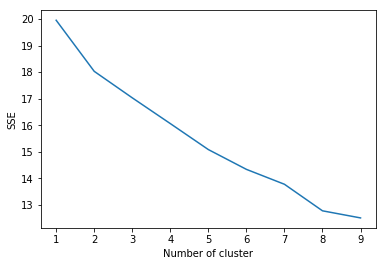

In [180]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

data = toronto_grouped_clustering
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [175]:
# set number of clusters
kclusters = 2

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [163]:
# add clustering labels
neighborhoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)

toronto_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood',how = 'right')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,1,Fast Food Restaurant,Women's Store,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0,Bar,History Museum,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Women's Store
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0,Mexican Restaurant,Medical Center,Electronics Store,Rental Car Location,Spa,Pizza Place,Intersection,Breakfast Spot,Department Store,Dessert Shop
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Korean Restaurant,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Athletics & Sports,Caribbean Restaurant,Hakka Restaurant,Bakery,Thai Restaurant,Bank,Fried Chicken Joint,Department Store,Dessert Shop,Dim Sum Restaurant


## Plot clusters!!!

In [208]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Explore clusters

Seems that park first cluster is about food and second one about parks and other outdoor activities

In [165]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,0,Bar,History Museum,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Women's Store
2,Scarborough,0,Mexican Restaurant,Medical Center,Electronics Store,Rental Car Location,Spa,Pizza Place,Intersection,Breakfast Spot,Department Store,Dessert Shop
3,Scarborough,0,Coffee Shop,Korean Restaurant,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
4,Scarborough,0,Athletics & Sports,Caribbean Restaurant,Hakka Restaurant,Bakery,Thai Restaurant,Bank,Fried Chicken Joint,Department Store,Dessert Shop,Dim Sum Restaurant
6,Scarborough,0,Discount Store,Coffee Shop,Chinese Restaurant,Department Store,Hobby Shop,Bus Station,Dumpling Restaurant,Drugstore,Eastern European Restaurant,Donut Shop
8,Scarborough,0,Motel,American Restaurant,Women's Store,Dance Studio,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
9,Scarborough,0,General Entertainment,College Stadium,Café,Skating Rink,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
10,Scarborough,0,Indian Restaurant,Pet Store,Light Rail Station,Vietnamese Restaurant,Latin American Restaurant,Chinese Restaurant,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant
11,Scarborough,0,Auto Garage,Smoke Shop,Breakfast Spot,Sandwich Place,Bakery,Women's Store,Dog Run,Dim Sum Restaurant,Diner,Discount Store
12,Scarborough,0,Lounge,Clothing Store,Sandwich Place,Breakfast Spot,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


In [166]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,1,Fast Food Restaurant,Women's Store,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
5,Scarborough,1,Playground,Women's Store,Dog Run,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
7,Scarborough,1,Bus Line,Bakery,Soccer Field,Park,Bus Station,Fast Food Restaurant,Metro Station,Diner,Dessert Shop,Dim Sum Restaurant
14,Scarborough,1,Park,Playground,Dog Run,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
23,North York,1,Bank,Park,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
25,North York,1,Park,Fast Food Restaurant,Food & Drink Shop,Bus Stop,Women's Store,Diner,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
30,North York,1,Park,Airport,Bus Stop,Electronics Store,Eastern European Restaurant,Empanada Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Dance Studio
40,East York,1,Park,Coffee Shop,Convenience Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
44,Central Toronto,1,Park,Bus Line,Swim School,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Dance Studio
50,Downtown Toronto,1,Park,Playground,Trail,Dumpling Restaurant,Drugstore,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Cupcake Shop
